In [83]:
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#reading saved file
filename='rsids.txt'
rsid = pd.read_csv(filename,sep="\t",)
rsid = pd.concat([rsid.drop('Genotypes',axis=1),pd.DataFrame(rsid.Genotypes.str.split('|',1).tolist(),columns = ['Genotypes','CallRate'])],axis=1)

In [95]:
"""
things to do in this function 
    1. remove duplicates based on call rates 
    2. Genotype check for --
"""

unique=[]
#segments are the fragments of the data with duplicate values
segments =[]

def checker(framesegment):
    if len(framesegment)==1:
        #all those with unique rsid's are registered 
        unique.extend(framesegment.index.tolist())
        return framesegment
    else:
        #rows with values automatically displayed on top and if all are -- alterative shows
        framesegment=framesegment.sort_values(by='CallRate',ascending=False)
        segments.extend(framesegment.index.tolist())
        return framesegment[:1]

ids=rsid.Annotation.unique()
d = pd.DataFrame()

for i in ids:
    df= rsid.loc[rsid['Annotation'] == i] 
    d=d.append(checker(df)) 
d=d.sort_values(by="Chr")
d['index'] = range(len(d))
d= d.set_index('index')



#to convert from str to a numeric data type
j = d.columns.get_loc('CallRate')
for i in range(1, len(d) + 1):
    try :
        d.iat[i - 1, j] = float(d.iat[i - 1, j])
    except :
        d.iat[i - 1, j] = 0
        pass

unique  = rsid.iloc[unique]   
repeats = rsid.iloc[segments]

uniqueGenotypes = unique.Genotypes.unique()

writer = pd.ExcelWriter('SNPdata.xlsx')
unique.to_excel(writer,'unique')
repeats.to_excel(writer,'repeatsdata')
writer.save()

['AA' 'AG' 'GG' 'CC' 'TT' 'TC' 'AC' 'II' 'TG' '--' 'TA']


In [99]:
#code below explains the visualisation of the data and how it has come about :

df=d
df['CallRate'] = df['CallRate'].astype('float')
df['z-score']= (df['CallRate'] - df['CallRate'].mean())/df['CallRate'].std(ddof=0)
df['Position'] = df['Position'].astype('int')

#arrays for the colors we will use to plot scatter poiny
colors = ['grey','black']
colours=[]
r=[]
y=[]

#assigning red& yellow
j = df.columns.get_loc('CallRate')
for i in range(1, len(df) + 1):
    if df.iat[i - 1, j]>.94 or df.iat[i - 1, j] <0:
        r.append(i - 1)
    elif .82<df.iat[i - 1, j]<.94 :
        y.append(i-1)

j = df.columns.get_loc('Chr')
for i in range(1, len(df) + 1):
    try :
        df.iat[i - 1, j] = int(df.iat[i - 1, j])
    except :
        pass

#assigning general colors in alternative pattern for viewing convenience
j=df.columns.get_loc('Chr')
for num in range(1,2931):
    try:
        colours.append(colors[(df.iloc[num,j] % 2)])
    except:
        colours.append('pink')

for i in range(0,len(r)):
    colours[r[i]]='red'
for i in range(0,len(y)):
    colours[y[i]]='yellow'        
k =  pd.Series(colours,name='colours')
df = pd.concat([df,k], axis=1)
df['ind'] = range(len(df))
#grouping the data on the basis of chromosome

df=df.sort_values(by=['Chr','Position'])
df['Chr'] = df['Chr'].astype('category')
df_grouped = df.groupby(('Chr'))



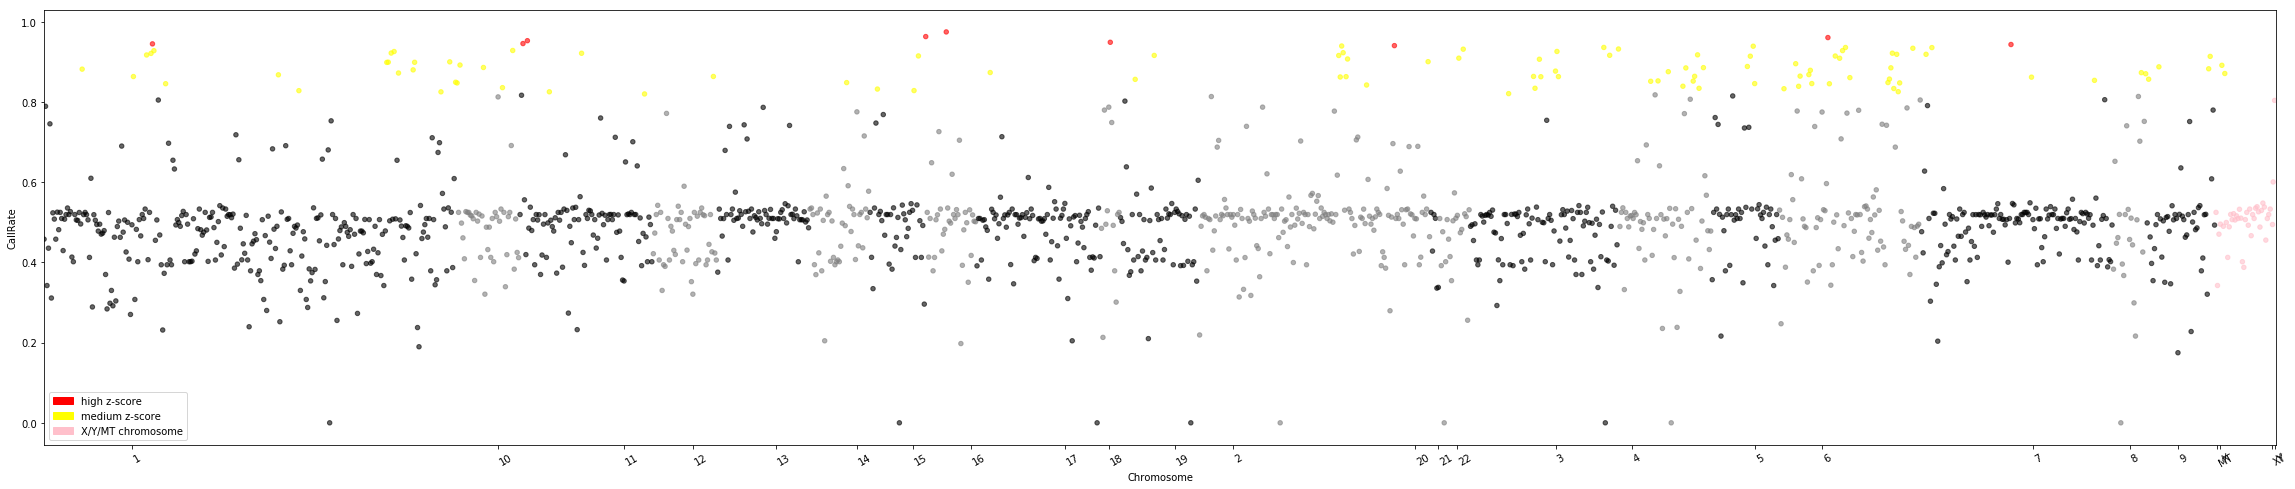

In [103]:
#creating the plot by looping through the groups ( created chromosomewise)
fig = plt.figure(figsize=[40,8])
ax = fig.add_subplot(1,1,1)

x_labels = []
x_labels_pos = []
prev=0
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='CallRate',color= group['colours'],ax=ax,alpha=0.6)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(d)])
ax.set_xlabel('Chromosome')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='left')


red_patch = mpatches.Patch(color='red', label='The red data')
yellow_patch = mpatches.Patch(color='yellow', label='The red data')
pink_patch = mpatches.Patch(color='pink', label='The red data')


plt.legend([red_patch,yellow_patch,pink_patch], ['high z-score','medium z-score',"X/Y/MT chromosome"])

plt.show()
